New Here:

- widget: ignore_atoms_per_group
- widget: spin selection
  - moved `plot()` down to module `Bandplot_matplotlib` cause independent of frontend
- widget: file chooser

# Setup

## Setup masci-tools path

In [1]:
# IMPORTANT: we need to import stuff from masci-tools folder.
# Since masci-tools is not installed as a module (yet), the notebook kernel
# needs to be started in the masci-tools folder.
# If that has not happened for some reason, then need to add the masci-tools
# manually to the sys path.
import os
import sys

cwd = os.getcwd()
path_mtools = cwd
dirname_mtools = "masci-tools"
# first try if we can get away without needing an absolute path
if dirname_mtools in path_mtools:
    while os.path.basename(path_mtools) != dirname_mtools:
        path_mtools = os.path.split(path_mtools)[0]
else:
    # okay, try with an absolute path
    path_mtools = "/home/johannes/Desktop/Studium/Kurse_RWTH/SiScLab/18W/repos/masci-tools"
    if not os.path.isdir(path_mtools):
        raise IOError(f"Could not find path to masci-tools. Please specify absolute path.")

# found masci-tools. add to syspath (for imports) and chdir.
if path_mtools not in sys.path:
    # add only once
    sys.path.append(path_mtools)

## Setup imports

In [2]:
# Jupyter, Python imports
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

#  python 3interactive figures in a live IPython notebook session
# if run from jupyter-notebook: MAGICmatplotlib nbagg
# if run from jupyter-lab: MAGICmatplotlib widget
%matplotlib widget

# studentproject18ws imports
import os
import logging
from studenproject18ws.hdf.reader import Reader
from studenproject18ws.hdf.recipes import Recipes
from studenproject18ws.plot.plot import Bandplot_matplotlib as Bandplot

## Read file, import data

- TODO: link with widget-based file-chooser

In [3]:
# filename = 'banddos.hdf'
filename = 'Co/banddos_Co.hdf'
# filename = 'banddos_4x4.hdf'
# filename = 'banddos_sodium.hdf'
# filename = os.path.join('MoSe2', 'banddos_2spin.hdf')

filepath = ['..', 'data', 'input', filename]
filepath = os.path.join(*filepath)

data = None
reader = Reader(filepath=filepath)
with reader as h5file:
    data = reader.read(recipe=Recipes.Bands)
    #
    # Note:
    # Inside the with statement (context manager),
    # all data attributes that are type h5py Dataset are available (in-file access)
    # When the statement is left,the HDF5 file gets closed and the datasets are closed.
    #
    # Use data outside the with-statement (in-memory access: all HDF5 datasets converted to numpy ndarrays):
    data.move_datasets_to_memory()

# Define Widgets

## Init data <--> plot interface

In [4]:
# init interface plot <--> data
bandplotter = Bandplot(data)

### Define user input arguments

In [5]:
ylim_data = bandplotter.get_data_ylim()
print(ylim_data)
select_ylim = widgets.FloatRangeSlider(
    value=ylim_data,
    min=ylim_data[0],
    max=ylim_data[1],
    step=(ylim_data[1]-ylim_data[0])/100,
    description='y range',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width="95%")
)

# number of bands can be large, so use a rangeslider instead of selectionslider
def_bands = [band for band in range(data.eigenvalues.shape[2])]
# select_bands_height = f"{len(def_bands)*5}px"
select_bands = widgets.IntRangeSlider(
    value=[def_bands[0]+1,def_bands[-1]+1],                            
    min=def_bands[0]+1, 
    max=def_bands[-1]+1, 
    step=1,                                    
    description='Bands',                              
    disabled=False, 
    continuous_update=False,                                    
    orientation='horizontal',
    readout=True,                                   
    readout_format='d',
    layout=select_ylim.layout
)

select_exponent = widgets.FloatSlider(
    value=1.0,
    min=0,
    max=4.0,
    step=0.01,
    description='Unfolding',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout=select_ylim.layout
)

select_marker_size = widgets.FloatSlider(
    value=1.0,
    min=0,
    max=10.0,
    step=0.01,
    description='Marker size',
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout=select_ylim.layout
)



select_compare_characters = widgets.Checkbox(
    value=False,
    description="",
    disabled=True,
#     style={'description_width': 'initial'} # for long descriptions
#     layout=widgets.Layout(width='30%', height='30%')
)

def_characters = ['s', 'p', 'd', 'f']
# Characters = namedtuple('Characters', ['s', 'p', 'd', 'f'])
# characters = Characters(0,1,2,3)
select_characters = widgets.SelectMultiple(
    options=def_characters,
    value=tuple(def_characters),
    description='',
    disabled=False,
#     layout=widgets.Layout(width='120%', height='90%')
)

# make compare_characters only available when 2 characters are selected
def on_character_selection_change(change):
    if len(change.new) == 2:
        select_compare_characters.disabled = False
#         select_compare_characters.description = "Compare 2 characters (enabled)"
    else:
        select_compare_characters.disabled = True
#         select_compare_characters.description = "Compare 2 characters (disabled)"
select_characters.observe(on_character_selection_change, names='value')

# when compare_characters is active, disable select_characters
def on_compare_character(change):
    select_characters.disabled = change.new
select_compare_characters.observe(on_compare_character, names='value')



# bands = atom_group_keys = e.g. for banddos.hdf: dict_keys[(1,2,3,4,5)]
#                           Hm... should better convert to tuple back in reader?
def_groups = data.atoms_group_keys
# select_groups_height = f"{len(def_groups)*19}px" # height just so no scrollbar needed
# select_groups_height = f"{len(def_groups)*10}px"
select_groups = widgets.SelectMultiple(
    options=def_groups,                                  
    value=tuple(def_groups),                                  
    description='',                                  
    disabled=False,
#     layout=widgets.Layout(width='20%', height='100%')
)


select_ignore_apg = widgets.Checkbox(
    value=False,
    description="Ignore atoms per group",
    disabled=False
)

def_spins = [spin for spin in range(data.num_spin)]
select_spins = widgets.SelectMultiple(
    options=def_spins,
    value=tuple(def_spins),
    description='',
    disabled=False
)



(-59.495991883250746, 26.44841993031685)


### Define Layout containers

In [6]:
# box_sliders = widgets.VBox([
#     select_ylim,
#     select_bands,
#     select_exponent,
#     select_marker_size
# ])
# box_sliders.layout=widgets.Layout(width='60%')
# box_characters = widgets.VBox([
#     widgets.Label("Characters"),
#     select_characters,
# #     widgets.HBox([select_compare_characters,widgets.Label('Compare 2')])
# ])
# # box_characters.layout=widgets.Layout(width='20%')
# box_groups = widgets.VBox([
#     widgets.Label("Atom Groups"),
#     select_groups
# ])
# # box_groups.layout=widgets.Layout(width='20%')
# box = widgets.HBox([box_sliders, box_characters, box_groups])

# display(box)

In [7]:
layout_auto = widgets.Layout(width='auto') #override default layouts
def override_layout(widgetss):
    for widget in widgetss:
        no_description=(widget.description=="")
        widget.layout=layout_auto
        if no_description:
            widget.description=''
        
def hbox_widget_label(wig, lab, wig_left=True):
    if wig_left:
        return widgets.HBox([wig,lab])
    else:
        return widgets.HBox([lab,wig])
#     wig.layout=layout_auto
#     lab.layout=layout_auto
#     hbox_layout = widgets.Layout(
#         display='flex',
#         flex_flow='row',
#         justify_content='space-between'
#     ) # this is def of HBox I think
#     children = None
#     if wig_left:
#         children = [wig,lab]
#     else:
#         children = [lab,wig]
#     box = widgets.Box(
#         children=children,
#         layout=hbox_layout
#     )
#     return box

selects_slider = [
    select_ylim,
    select_bands,
    select_exponent,
    select_marker_size
]
override_layout(selects_slider)
layout_box_sliders = widgets.Layout(
    display='flex',
    flex_flow='column',
    align_items='stretch',
    border='solid',
    width='60%'
)
box_sliders = widgets.Box(
    children=selects_slider,
    layout=layout_box_sliders
)


label_characters = widgets.Label("Characters")
label_compare_characters = widgets.Label("Compare 2")
selects_character = [
    label_characters,
    select_characters,
    label_compare_characters,
    select_compare_characters
]
override_layout(selects_character)
select_characters.description=''
# selects_character.append(hbox_widget_label(
#     select_compare_characters, 
#     label_compare_characters, wig_left=False))
layout_box_characters = widgets.Layout(
    display='flex',
    flex_flow='column',
    align_items='stretch',
    border='solid',
    width='20%'
)
box_characters = widgets.Box(
    children=selects_character,
    layout=layout_box_characters
)


label_groups = widgets.Label("Atom Groups")
selects_group = [
    label_groups,
    select_groups
]
override_layout(selects_group)
select_groups.description=''
box_groups = widgets.Box(
    children=selects_group,
    layout=layout_box_characters
)

dashboard_controls = widgets.HBox([box_sliders, box_characters, box_groups])
# display(dashboard_controls)

## Interact funtion using `interactive`

Checkbox(value=False, description='Ignore atoms per group')

SelectMultiple(description='spins', index=(0, 1), options=(0, 1), value=(0, 1))

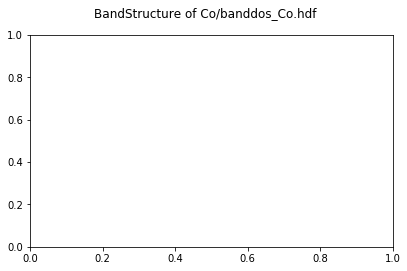

In [8]:
# init plot
fig_scale = 0.65
fig_ratio = [10,6]
fig, ax = plt.subplots(1, figsize=[fig_scale * el for el in fig_ratio])
plt.suptitle(f"BandStructure of {filename}")


def update_plot(characters, groups, bands, spins,
                unfolding_weight_exponent, marker_size,
               compare_characters, ylim, ignore_atoms_per_group):
    ax.clear()
    ax.set_ylim(ylim)
    
    # setup plt figure labels
    bandplotter.setup(plt)
    
    # convert arguments to the expected format for code 181124
    bands_conved = range(bands[0]-1,bands[1])
    groups_conved = [el-1 for el in groups]
    characters_conved = [def_characters.index(el) for el in characters]
    
    # convert arguments to the expected format for code 181212
    mask_characters = [el in characters for el in def_characters]
    mask_bands = [el in bands_conved for el in def_bands]
    mask_groups = [el in [el for el in groups] for el in def_groups]

    bandplotter.plot(mask_bands, mask_characters, mask_groups, spins,
                     unfolding_weight_exponent, compare_characters, ax, 
                     ignore_atoms_per_group, marker_size)
    plt.show()

    
interactive_update_plot = interactive(
    update_plot, 
    characters=select_characters, groups=select_groups, 
    bands=select_bands, spins=select_spins,
    unfolding_weight_exponent=select_exponent, marker_size=select_marker_size,
    compare_characters=select_compare_characters, ylim=select_ylim,
    ignore_atoms_per_group=select_ignore_apg
)


# dashboard = widgets.VBox()
# dashboard_plot = widgets.VBox(interactive_update_plot.children)
# dashboard_plot.layout.display='none'
# dashboard.children = [dashboard_plot,
#                      dashboard_controls]

select_characters.description=''
select_groups.description=''
display(dashboard_controls)
# TODO: integrate into dashboard:
display(select_ignore_apg)
display(select_spins)

## 3D Atoms plot

In [11]:
import ipyvolume as ipv
x, y, z = data.atoms_position.T
@interact(groups=select_groups)
def update_atoms_plot(groups):
    selected_atoms = []
    for group in groups:
        selected_atoms_group = np.where(data.atoms_group==group)
        for selected_atom_group in selected_atoms_group:
            selected_atoms.extend(selected_atom_group)
    
    ipv.figure()
    scatter = ipv.scatter(x,y,z, size=5, marker="sphere", selected=selected_atoms, size_selected=8)
    ipv.show()

    

interactive(children=(SelectMultiple(description='groups', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

(-3.9357437737417897, 11.969520809868719)